# Pneumonia Detection 

## Project Overview 
This project involves building a convolutional neural network (CNN) to classify medical X-ray images and detect pneumonia. Targeted at beginner to intermediate-level data scientists, the project will focus on leveraging deep learning techniques to develop a robust classification model. The final model will be deployed using Streamlit, providing a user-friendly interface for real-time predictions.

### Import Libraries

In [104]:
import numpy as np 
from PIL import Image
import random as rand
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomShear
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [38]:
# What version of tensorflow are we working with? 
tf.__version__

'2.18.0'

## Week 2: Data Preprocessing

### Number of images BEFORE removing from folder for corruption 

In [ ]:
# How many images are we dealing with? 
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join('../../data/chest_xray/train', folder_name)
    image_list = os.listdir(folder_path)
    if (folder_name == 'NORMAL'): 
        print(f'NORMAL IMAGE COUNT TRAIN SET: {len(image_list)}')
    else: 
        print(f'PNEUMONIA IMAGE COUNT TRAIN SET: {len(image_list)}')

NORMAL IMAGE COUNT TRAIN SET: 1341
PNEUMONIA IMAGE COUNT TRAIN SET: 3875


### Filter out corrupted images (if any)

In [25]:
num_skipped = 0
# Delete images based on not having JFIF in header
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join('../../data/chest_xray/train', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 173 images.


### Visualize the training dataset BEFORE applying transformation

In [78]:
# How many images are we dealing with? 
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join('../../data/chest_xray/train', folder_name)
    image_list = os.listdir(folder_path)
    if (folder_name == 'NORMAL'): 
        print(f'NORMAL IMAGE COUNT TRAIN SET: {len(image_list)}')
    else: 
        print(f'PNEUMONIA IMAGE COUNT TRAIN SET: {len(image_list)}')

NORMAL IMAGE COUNT TRAIN SET: 1300
PNEUMONIA IMAGE COUNT TRAIN SET: 3743


In [79]:
def display_image_from_path(image_path):
    """Displays an image from a specified folder path."""
    if not os.path.exists(image_path):
        print(f"Error: The file at '{image_path}' does not exist.")
        return
    
    image_name = os.path.basename(image_path) # Extract filename 
    image = Image.open(image_path)  # Open image
    plt.imshow(image)
    plt.title(image_name) # Set filename as title
    #plt.axis('off')  # Hide axis for better visualization
    plt.show()

In [80]:
normal_fpath = []
pneumonia_fpath = []

for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join('../../data/chest_xray/train', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if (folder_name == 'NORMAL'): 
            normal_fpath.append(fpath)
        else: 
            pneumonia_fpath.append(fpath)

In [81]:
print('NORMAL IMAGE PATH TRAIN SET')
print(normal_fpath)
print(len(normal_fpath))
print('\n')
print('PNEUMONIA IMAGE PATH TRAIN SET')
print(pneumonia_fpath)
print(len(pneumonia_fpath))

NORMAL IMAGE PATH TRAIN SET
['../../data/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0117-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0119-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0122-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0125-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0127-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0128-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0129-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0131-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0133-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0135-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0137-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0140-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0141-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0143-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0145-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-01

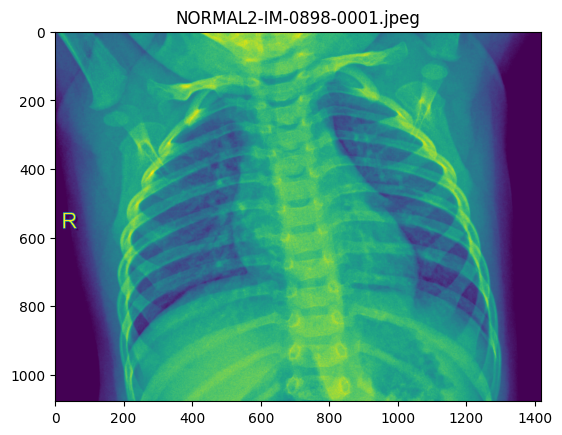

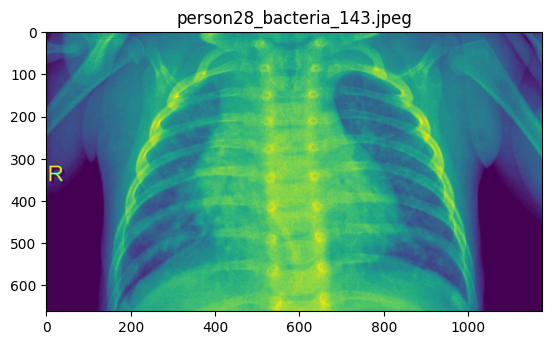

In [82]:
normal_rand_num = rand.randint(0, len(normal_fpath) - 1)
pneumonia_rand_num = rand.randint(0,len(pneumonia_fpath) - 1)

display_image_from_path(normal_fpath[normal_rand_num])
display_image_from_path(pneumonia_fpath[pneumonia_rand_num])


### Transform the images to a standard size and normalize pixel values

In [93]:
image_size = (180, 180)
batch_size = 128

# Training set 
training_set = image_dataset_from_directory(
    '../../data/chest_xray/train', 
    image_size=image_size, # Resizing the images to a uniform size 
    batch_size=batch_size # How many images to have in each batch?
)

# Validation set 
validation_set = image_dataset_from_directory(
    '../../data/chest_xray/val',
    image_size=image_size, 
    batch_size=batch_size
)

# Testing set 
testing_set = image_dataset_from_directory(
    '../../data/chest_xray/test',
    image_size=image_size,
    batch_size=batch_size
)


Found 5043 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [89]:
# Find class names of training dataset 
class_names = training_set.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Visualize the training dataset AFTER resizing

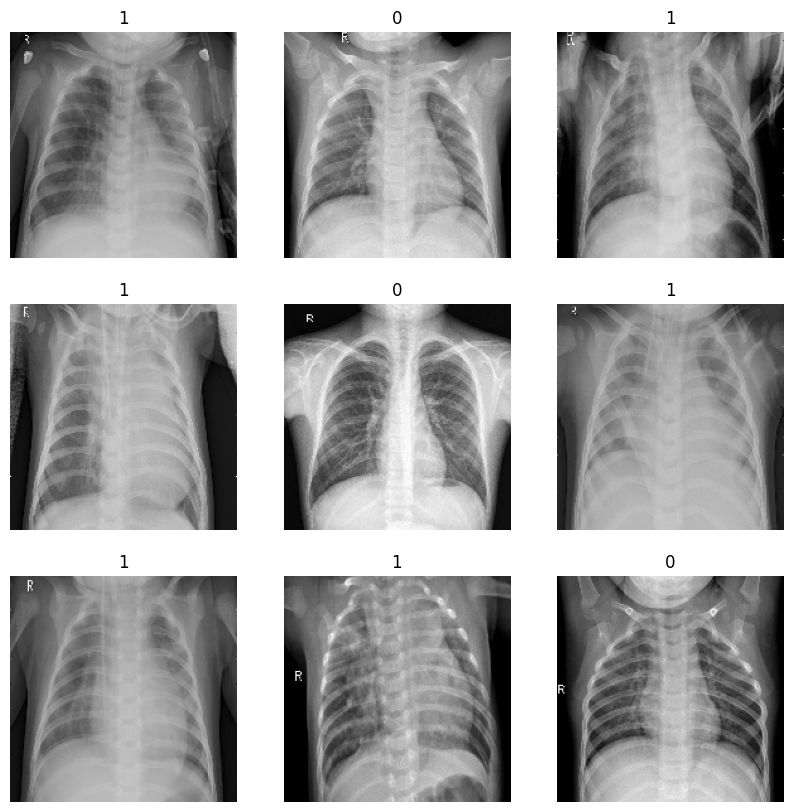

In [92]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [95]:
# Print shape of the image in your training set
for image_batch, labels_batch in training_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# image_batch: (128, 180, 180, 3) - Batch of 128 images of 180x180x3
# label_batch: (128,) - Corresponds to labels for 128 images 

(128, 180, 180, 3)
(128,)


In [97]:
# Rescale the images to a normal value 
normalization_layer = Rescaling(1./255)

In [ ]:
# Normalize training dataset
normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_training_set))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99117655


In [100]:
# Normalize testing dataset 
normalized_testing_set = testing_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_testing_set))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99907833


### Apply image augmentation to the training dataset

In [106]:
data_augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2), 
    RandomShear(0.2)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

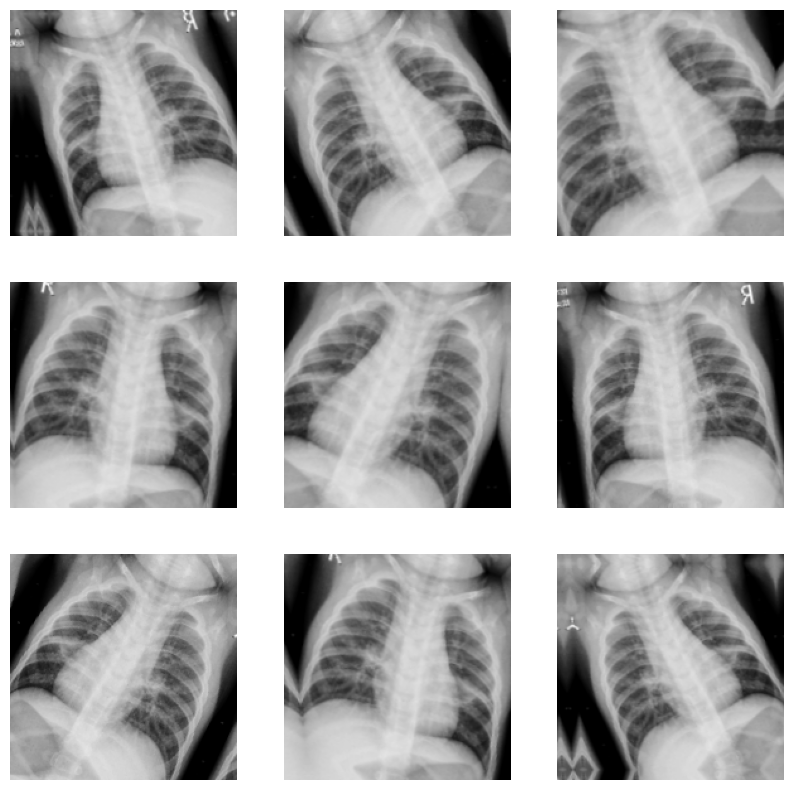

In [107]:
# Visualize these transformations
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")